# Manipulator Example
Based on Astrobee example.

Emiko Soroka, AA 203 final project

In [1]:
# If first time running this code on a personal computer
# using Pkg
# Pkg.instantiate()

### Script / GuSTO Initialization

In [155]:
# Initializing script
using LinearAlgebra
using Ipopt
using JuMP
using DifferentialEquations
using NLsolve
using Plots

include("./SCP/gusto_problem.jl")
println("Included GuSTO")
include("./Models/manipulator.jl")
println("Included manipulator")

# Number of time-discretization points and maximum number of GuSTO iterations
N, max_it = 300, 20

Deltas  = ones(max_it)*Inf
rhos    = ones(max_it)*Inf
metrics = ones(max_it)*Inf

# Defining the model, the initial strategy and each convex subproblem
model      = Manipulator()
Xp,Up      = initialize_trajectory(model,N)

SCPproblem = GuSTOProblem(model,N,Xp,Up)

println("h = ", model.h)
# h is the discretization step
# if it's too big, you need to make N bigger on line 15.
# You can tell h is too big, if you get the error
# "Reject solution: the linearization is too coarse."

# Defining GuSTO parameters
(Delta0, omega0, omegamax, epsilon, rho0,
        rho1, beta_succ, beta_fail, gamma_fail, 
        convergence_threshold) = get_initial_gusto_parameters(model)

Included GuSTO
Included manipulator
h = 0.0033333333333333335


(100.0, 500.0, 1.0e6, 0.001, 50.0, 100.0, 2.0, 0.5, 5.0, 2.5)

### GuSTO Algorithm

In [156]:
# Defining penalization weights, trust-region radius and the list of solutions
Xp,Up        = initialize_trajectory(model,N)
X, U         = copy(Xp), copy(Up)
omega, Delta = omega0, Delta0
X_all, U_all = [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

# GuSTO loop
success, it = false, 1
while it < max_it                                                               && 
      #!(success && convergence_metric(model,X,U,Xp,Up) < convergence_threshold) &&
      omega < omegamax
    println("-----------\nIteration $it\n-----------")
    
    # Storing the solution at the previous step and the linearized dynamics
    Xp, Up                    = copy(X), copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model,Xp,Up)
    
    # Defining the convex subproblem
    reset_problem(     SCPproblem, model)
    set_parameters(    SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(       SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    # Solving the convex subproblem
    JuMP.optimize!(SCPproblem.solver_model)
    X_sol, U_sol = JuMP.value.(SCPproblem.X), JuMP.value.(SCPproblem.U)
    
    # -----------
    # GuSTO Logic
    
    # Trust-region constraints are satisfied
    
    #println("X_sol, U_sol\n")
    #for i=1:N
    #    println(X[:,i])
    #    if i != N
    #        println(U[:,i])
    #    end
    #end

    println("Delta = ", Delta)
    Deltas[it] = Delta
    if is_in_trust_region(model,X_sol,U_sol,Xp,Up,Delta)
        
        # Computing accuracy ratio rho
        rho = accuracy_ratio(SCPproblem,model,X_sol,U_sol,Xp,Up)
        println("rho = ", rho)
        rhos[it] = rho
        # Too coarse linearization: reject solution
        if rho > rho1
            println("Reject solution (the linearization is too coarse).")
            Delta, omega = beta_fail*Delta, omega
            success      = false
        
        # Accepting solution
        else
            println("Accept solution.")
            X, U    = copy(X_sol), copy(U_sol)
            success = true
            
            # Check precision of linearization
            if rho < rho0
                Delta = min(beta_succ*Delta,Delta0) # Optimal / Precise 
            else
                Delta = Delta                       # Imprecise - bad
            end
            
            # Check satisfaction of state constraints
            if satisfies_state_inequality_constraints(SCPproblem,model,X_sol,U_sol,Xp,Up,Delta)
                omega = omega0 # All constraints are satisfied - good
            else
                # State constraints are not satisfied: increase penalization weights
                println("Solution does not satisfy state constraints, increasing omega.")
                omega   = gamma_fail*omega
                success = false
            end
        end
        
    # Trust-region constraints are NOT satisfied
    else
        println("Reject solution (the trust region constraints are not satisfied).")
        Delta   = Delta
        omega   = gamma_fail*omega
        success = false
    end

    # Collecting the solution at each iteration
    push!(X_all,copy(X))
    push!(U_all,copy(U))
    it += 1
    
    println("Parameters:")
    
    # We want the metric to be small.
    # This shows the previous trajectory/control Xp, Up
    # is close to the new one X, U.
    metric = convergence_metric(model,X,U,Xp,Up)
    metrics[it] = metric
    println("metric = $metric")

end

-----------
Iteration 1
-----------
Delta = 100.0
rho = 62.138751944966835
Accept solution.
Parameters:
metric = 45.9663013022618
-----------
Iteration 2
-----------
Delta = 100.0
rho = 12.475210469278197
Accept solution.
Parameters:
metric = 26.430397611605915
-----------
Iteration 3
-----------
Delta = 100.0
rho = 13.53078042504226
Accept solution.
Parameters:
metric = 24.240551013371025
-----------
Iteration 4
-----------
Delta = 100.0
rho = 7.753481128074346
Accept solution.
Parameters:
metric = 20.452629739089755
-----------
Iteration 5
-----------
Delta = 100.0
rho = 6.8618332960167665
Accept solution.
Parameters:
metric = 17.19555266162764
-----------
Iteration 6
-----------
Delta = 100.0
rho = 8.856975256250992
Accept solution.
Parameters:
metric = 23.24795261463058
-----------
Iteration 7
-----------
Delta = 100.0
rho = 9.976799824320164
Accept solution.
Parameters:
metric = 20.21541408851916
-----------
Iteration 8
-----------
Delta = 100.0
rho = 14.448234362387241
Accept sol

# Plots

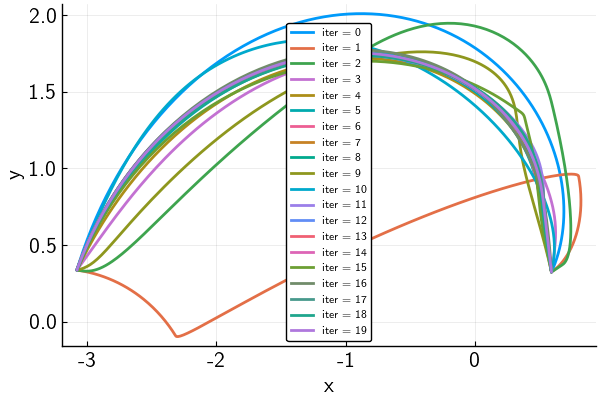

In [98]:
include("manipulator_plotting.jl")
include("Models/polygonal_obstacles.jl")
plot_solutions(SCPproblem, model, X_all, U_all)

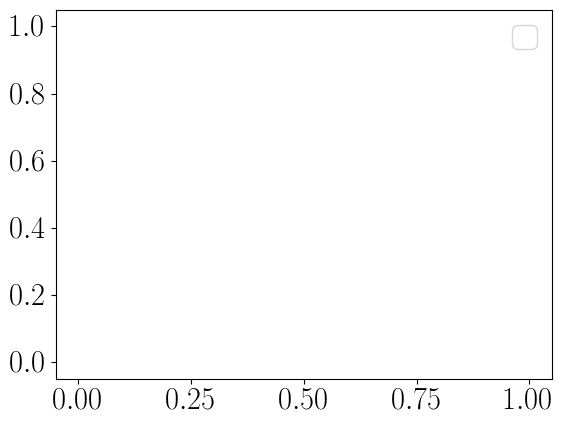

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = #plt_3D_solutions#135(::Array{Float64,1}, ::Array{Float64,1}, ::Tuple{Int64,Int64}, ::Bool, ::typeof(plt_3D_solutions), ::GuSTOProblem, ::Manipulator, ::Array{Any,1}, ::Array{Any,1}) at manipulator_plotting.jl:100
└ @ Main /home/esoroka/Desktop/localfiles/AA203_local/project/GuSTO_quad_astrobee/manipulator_plotting.jl:100
No handles with labels found to put in legend.


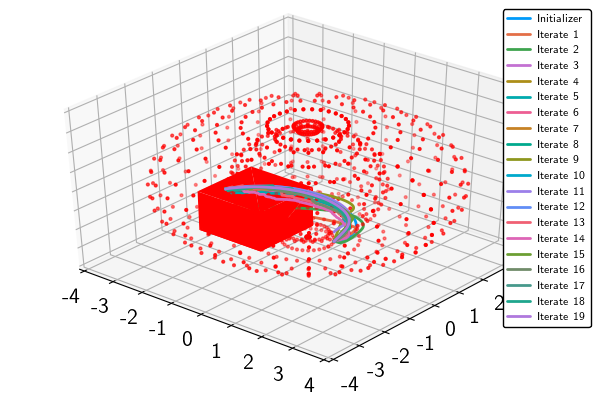

In [99]:
plt_3D_solutions(SCPproblem, model, X_all, U_all)

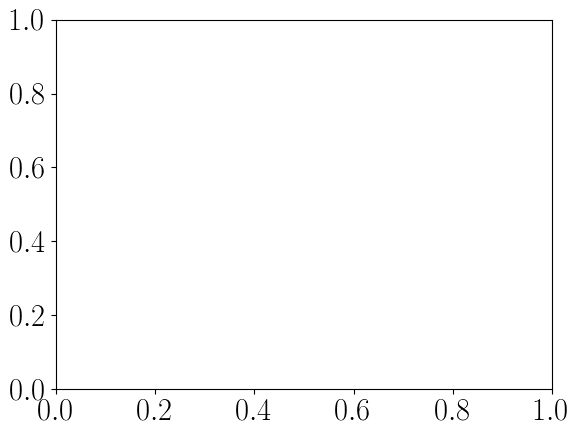

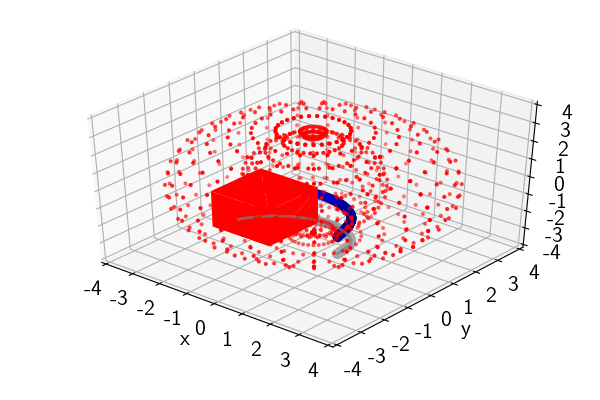

In [100]:
plot3D_final_solution(SCPproblem, model, X_all[end], U_all[end])

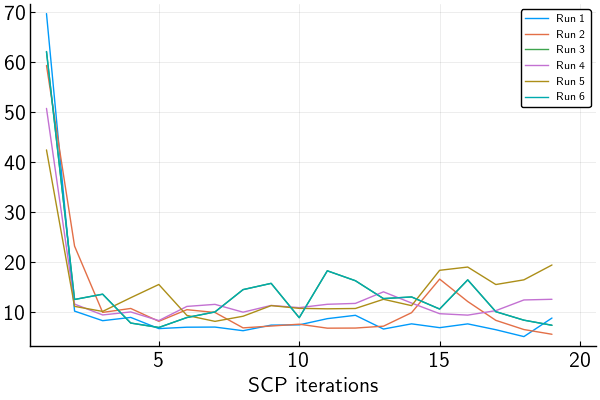

In [158]:
plot(rhos_collection[:,3], label="Run 1")
for i=5:9
    plot!(rhos_collection[:,i], label="Run $(i-3)", legend=true)
end
xlabel!("SCP iterations")

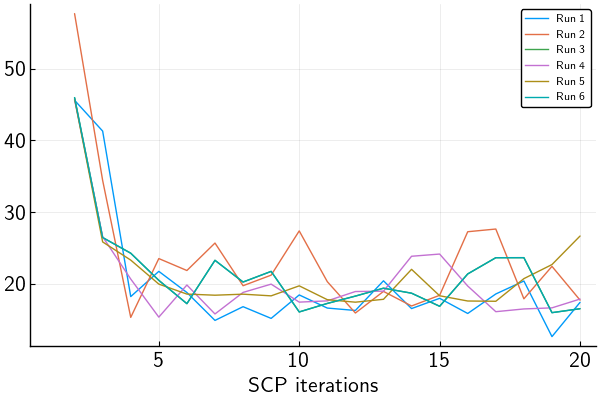

In [159]:
plot(metrics_collection[:,3], label="Run 1")
for i=5:9
    plot!(metrics_collection[:,i], label="Run $(i-3)", legend=true)
end
xlabel!("SCP iterations")

In [ ]:
#rhos_collection = Array{Float64}(undef, max_it, 5)
#metrics_collection = Array{Float64}(undef, max_it, 5)

In [157]:
rhos_collection = hcat(rhos_collection, rhos)
metrics_collection = hcat(metrics_collection, metrics)

20×9 Array{Float64,2}:
 Inf          Inf         Inf       Inf       …  Inf       Inf       Inf     
  53.1931      46.1821     45.5928   53.2668      45.7049   45.8063   45.9663
  36.3915      45.3374     41.2914   50.4091      26.5385   25.8157   26.4304
   8.51013     16.1835     18.182    21.0161      20.6336   23.2764   24.2406
  13.0047       6.58887    21.7066   26.4593      15.315    19.9272   20.4526
  10.1875       6.78902    18.7517   35.1188  …   19.8011   18.5328   17.1956
  10.4594       6.7343     14.8578   28.1014      15.756    18.3761   23.248 
   7.99738      1.32616    16.773    30.2887      18.7646   18.519    20.2154
  25.6053       0.712196   15.1385   30.3987      19.9227   18.2857   21.7014
   2.6927      11.3686     18.4141   28.5497      17.4103   19.6843   16.0389
  11.8192      14.4096     16.5808   32.3318  …   17.5849   17.7507   17.2275
  11.6296      10.1946     16.2454   26.1818      18.8903   17.4024   18.252 
   0.968458     9.63192    20.3871   27.8